<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056 (from 1)
Receiving objects: 100% (4056/4056), 646.90 MiB | 38.94 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Get data 

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data/pizza_steak_sushi directory exists.


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x103dd1c30>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [15]:
# Setup the model with pretrained weights and send it to the target device 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_0 = torchvision.models.efficientnet_b0(weights=weights)
#model_0 # uncomment to output (it's very long)

In [16]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [17]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [18]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [19]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1034 | train_acc: 0.3828 | test_loss: 0.8918 | test_acc: 0.5701
Epoch: 2 | train_loss: 0.9392 | train_acc: 0.6602 | test_loss: 0.8103 | test_acc: 0.7027
Epoch: 3 | train_loss: 0.7618 | train_acc: 0.8945 | test_loss: 0.6448 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7616 | train_acc: 0.6992 | test_loss: 0.5864 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6327 | train_acc: 0.8789 | test_loss: 0.6041 | test_acc: 0.9072
[INFO] Total training time: 385.375 seconds


### Make predictions on the entire test dataset with the model

In [99]:
# TODO
torch.manual_seed(42)
model_0.eval()

with torch.inference_mode():
    test_preds = []
    test_probas = []
    for X, y in test_dataloader:
        pred_logits = model_0(X)
        pred_proba = torch.softmax(pred_logits, dim=1)
        test_pred = pred_proba.argmax(dim=1)
        test_preds.append(test_pred)
        test_probas.append(pred_proba)
    test_preds = torch.cat(test_preds)
    test_probas = torch.cat(test_probas)
    
    print(test_preds)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])


In [87]:
test_probas[0].max()

tensor(0.7745)

In [25]:
torch.cat(test_preds)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [27]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [28]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


In [33]:
# TODO

test_true= [y for X, y in test_dataloader]
test_true = torch.cat(test_true)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

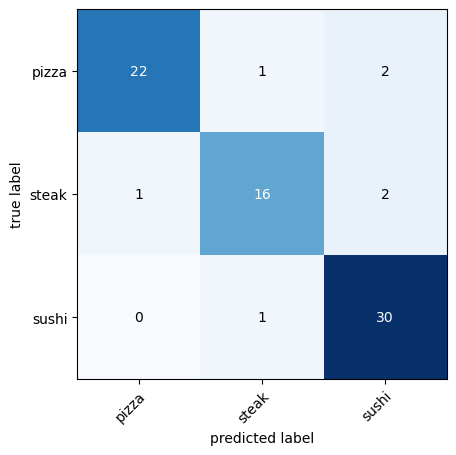

In [42]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# setup confusion matrix instance
conf_mat = ConfusionMatrix(task='MULTICLASS', num_classes= len(class_names))
conf_mat_tensor = conf_mat(preds=test_preds,
                           target=test_true)
conf_mat_tensor

plot_confusion_matrix(
    conf_mat=conf_mat_tensor.numpy(),
    class_names=class_names
    
)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)

* Plot the top 5 "most wrong" image predictions

In [121]:
from tqdm import tqdm

# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class
  
    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model_0,
                                 transform=simple_transform,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 32.94it/s]


[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7478915452957153,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.6711027026176453,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7437126040458679,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.6770445108413696,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.46754223108291626,
  'pred_class': 'steak',
  'correct': True}]

In [123]:
test_pred_dicts_df = pd.DataFrame(test_pred_dicts)
test_pred_dicts_df.head()

,image_path,class_name,pred_prob,pred_class,correct
0,data/pizza_steak_sushi/test/steak/296375.jpg,steak,0.747892,steak,True
1,data/pizza_steak_sushi/test/steak/673127.jpg,steak,0.671103,steak,True
2,data/pizza_steak_sushi/test/steak/894825.jpg,steak,0.743713,steak,True
3,data/pizza_steak_sushi/test/steak/1868005.jpg,steak,0.677045,steak,True
4,data/pizza_steak_sushi/test/steak/27415.jpg,steak,0.467542,steak,True


In [136]:
incorrect_5 = test_pred_dicts_df[test_pred_dicts_df['correct'] == False].sort_values('pred_prob', ascending=False).head()
incorrect_5

,image_path,class_name,pred_prob,pred_class,correct
37,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.509456,steak,False
52,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.454934,sushi,False
72,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.427036,steak,False
6,data/pizza_steak_sushi/test/steak/1285886.jpg,steak,0.422380,sushi,False
18,data/pizza_steak_sushi/test/steak/1627703.jpg,steak,0.389061,sushi,False


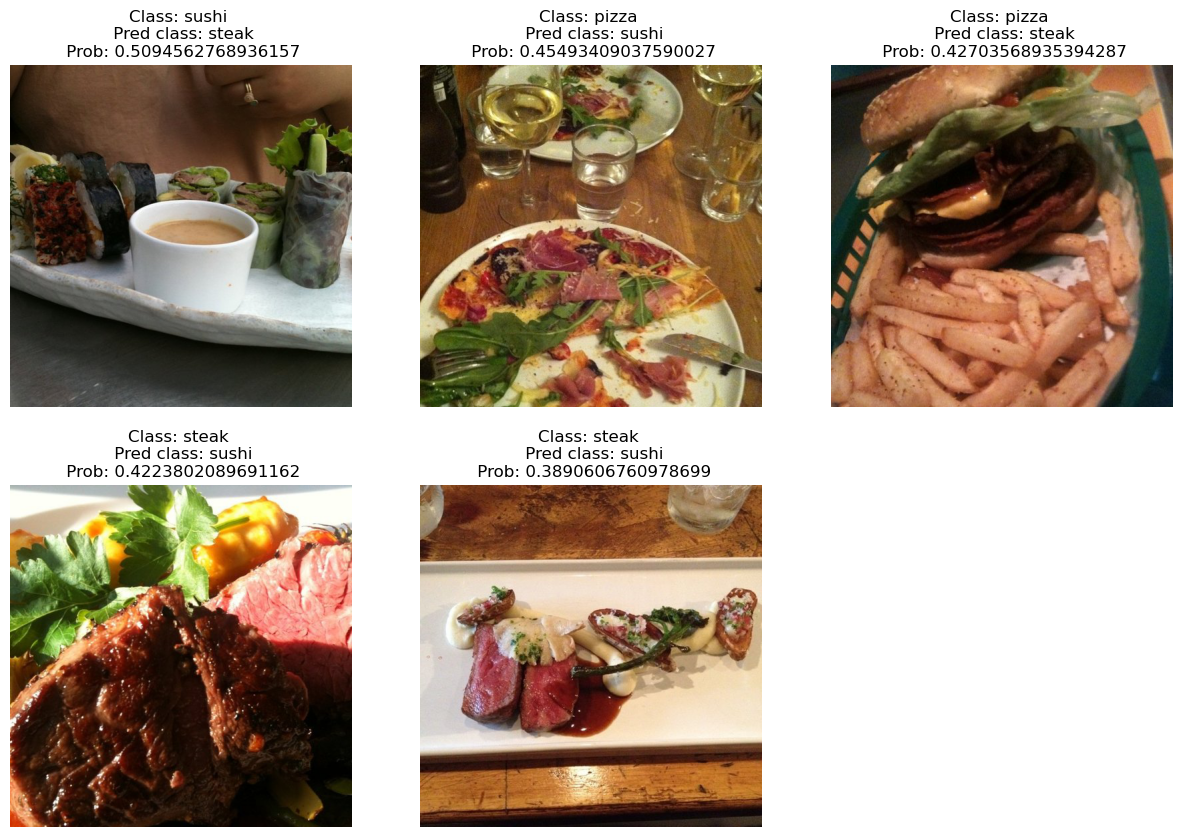

In [162]:
from PIL import Image

image_path = list(incorrect_5['image_path'])
class_name = list(incorrect_5['class_name'])
pred_prob = list(incorrect_5['pred_prob'])
pred_class = list(incorrect_5['pred_class'])
correct = list(incorrect_5['correct'])

plt.figure(figsize=(15,10))
for i in range(len(incorrect_5)):
    img = Image.open(Path(image_path[i]))
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f'Class: {class_name[i]} \n Pred class: {pred_class[i]}\n Prob: {pred_prob[i]}')
    plt.axis(False)

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


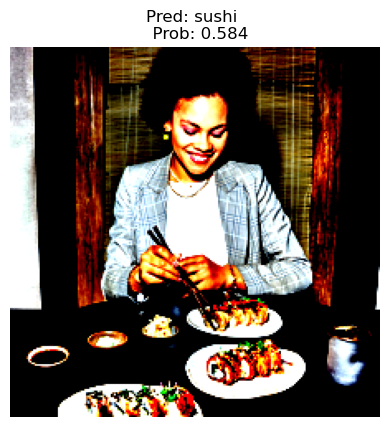

In [173]:
# TODO: Get an image of pizza/steak/sushi
test_image = Image.open(data_path / 'sushi_eating.jpg')
tranformed_test_image = weights.transforms()(test_image)
plt.imshow(tranformed_test_image.permute(1,2,0))

model_0.eval()
with torch.inference_mode():
    pred_logits = model_0(tranformed_test_image.unsqueeze(0))
    y_pred_proba = torch.softmax(pred_logits, dim=1)
    y_pred = y_pred_proba.argmax(dim=1)

    plt.imshow(tranformed_test_image.permute(1,2,0))
    plt.title(f'Pred: {class_names[y_pred]} \n  Prob: {y_pred_proba.max():.3f}')
    plt.axis(False)

In [ ]:
model_0.features.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


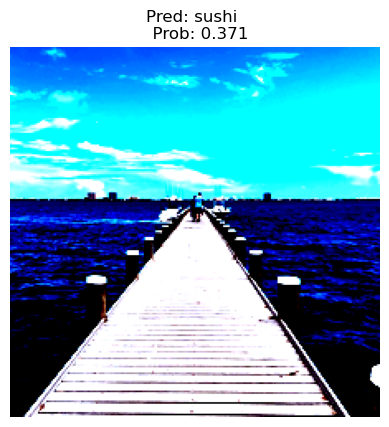

In [174]:
# TODO: Get an image of not pizza/steak/sushi
test_image = Image.open(data_path / 'non_food.jpg')
tranformed_test_image = weights.transforms()(test_image)
plt.imshow(tranformed_test_image.permute(1,2,0))

model_0.eval()
with torch.inference_mode():
    pred_logits = model_0(tranformed_test_image.unsqueeze(0))
    y_pred_proba = torch.softmax(pred_logits, dim=1)
    y_pred = y_pred_proba.argmax(dim=1)

    plt.imshow(tranformed_test_image.permute(1,2,0))
    plt.title(f'Pred: {class_names[y_pred]} \n  Prob: {y_pred_proba.max():.3f}')
    plt.axis(False)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [180]:
# TODO: Recreate a new model 
import torchvision
from torch import nn

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights=weights)

#freeze the features
for param in model_1.features.parameters():
    param.requires_grad = False

# change the classifier head
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=3, bias=True)
)


In [182]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

In [184]:
# TODO: Train the model for 10 epochs

model_1_results = engine.train(model=model_1,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         epochs=10,
                         loss_fn=loss_fn,
                         optimizer=optimizer, device=device)
model_1_results

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0690 | train_acc: 0.3750 | test_loss: 0.8822 | test_acc: 0.7112
Epoch: 2 | train_loss: 0.9253 | train_acc: 0.6094 | test_loss: 0.6769 | test_acc: 0.8854
Epoch: 3 | train_loss: 0.7670 | train_acc: 0.7188 | test_loss: 0.6835 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.7293 | train_acc: 0.7539 | test_loss: 0.6862 | test_acc: 0.7850
Epoch: 5 | train_loss: 0.6053 | train_acc: 0.7734 | test_loss: 0.5394 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.5904 | train_acc: 0.8633 | test_loss: 0.4886 | test_acc: 0.9375
Epoch: 7 | train_loss: 0.6302 | train_acc: 0.7422 | test_loss: 0.4593 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.5355 | train_acc: 0.7969 | test_loss: 0.4923 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.5060 | train_acc: 0.7969 | test_loss: 0.4711 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.4907 | train_acc: 0.8281 | test_loss: 0.4913 | test_acc: 0.9072


{'train_loss': [1.0690412148833275,
  0.9253324791789055,
  0.7669910117983818,
  0.7292638421058655,
  0.6052684336900711,
  0.5904051177203655,
  0.6301886774599552,
  0.5354543924331665,
  0.5059780403971672,
  0.49073953554034233],
 'train_acc': [0.375,
  0.609375,
  0.71875,
  0.75390625,
  0.7734375,
  0.86328125,
  0.7421875,
  0.796875,
  0.796875,
  0.828125],
 'test_loss': [0.882246216138204,
  0.6769058307011923,
  0.6835354963938395,
  0.6861648559570312,
  0.5393542448679606,
  0.4886443018913269,
  0.4593184490998586,
  0.49230098724365234,
  0.47112656633059186,
  0.4913163681825002],
 'test_acc': [0.7111742424242425,
  0.8854166666666666,
  0.8967803030303031,
  0.7850378787878788,
  0.9176136363636364,
  0.9375,
  0.8863636363636364,
  0.9280303030303031,
  0.9280303030303031,
  0.9071969696969697]}

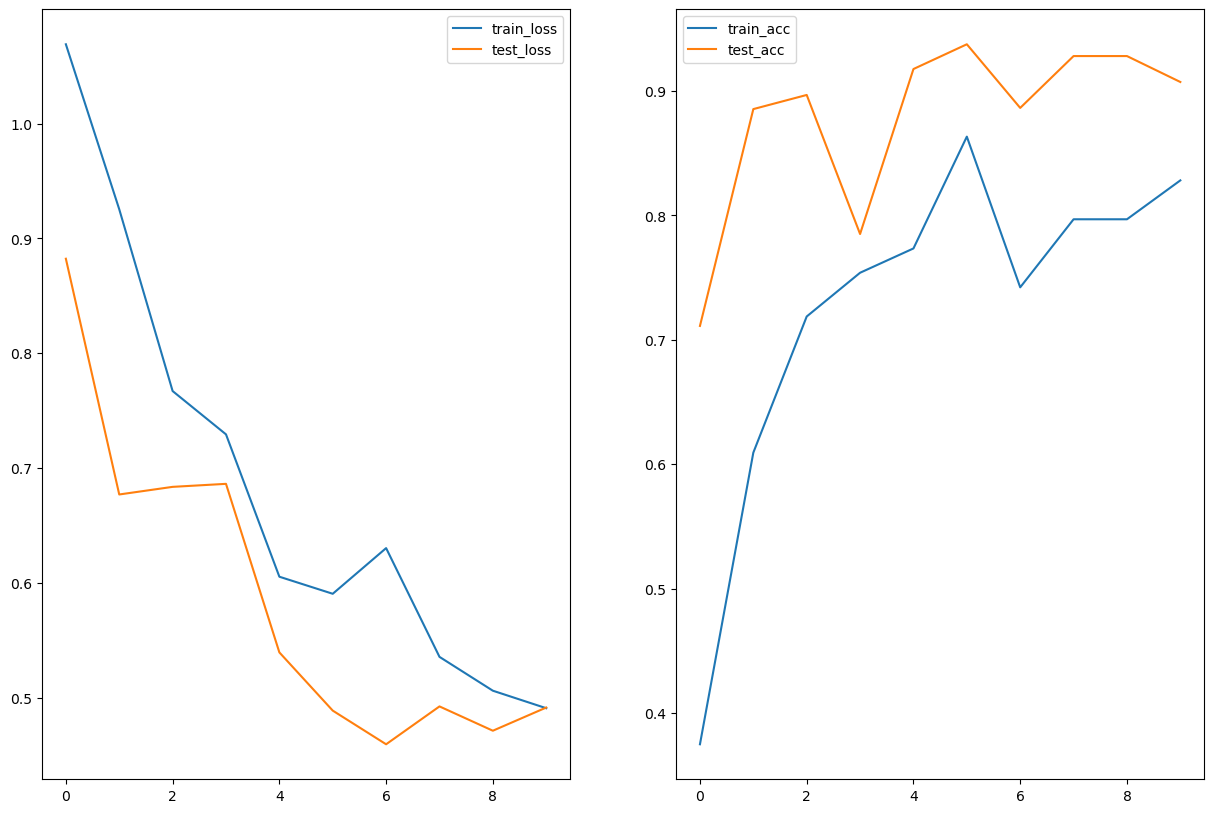

In [188]:

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(model_1_results['train_loss'], label='train_loss')
plt.plot(model_1_results['test_loss'], label='test_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(model_1_results['train_acc'], label='train_acc')
plt.plot(model_1_results['test_acc'], label='test_acc')
plt.legend()

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

In [189]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [191]:
auto_transform = weights.transforms()

In [192]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=auto_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x151509000>,
 ['pizza', 'steak', 'sushi'])

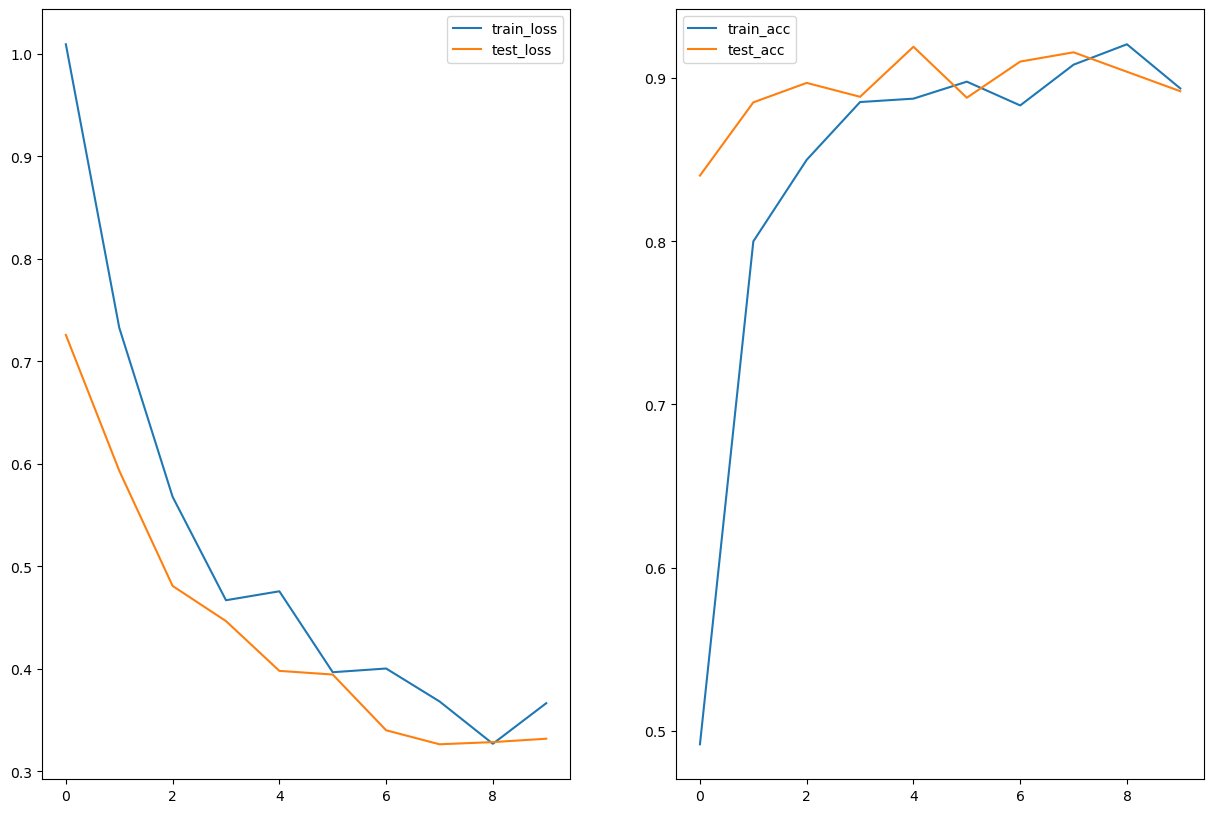

In [195]:

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(model_2_results['train_loss'], label='train_loss')
plt.plot(model_2_results['test_loss'], label='test_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(model_2_results['train_acc'], label='train_acc')
plt.plot(model_2_results['test_acc'], label='test_acc')
plt.legend()

### Get a pretrained model

In [193]:
# TODO
weights_2 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights=weights_2)

# freeze param
for param in model_2.features.parameters():
    param.requires_grad = False

# reset classifier
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=3, bias=True)
)

### Train a model with 20% of the data

In [194]:
# TODO
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.001)
model_2_results = engine.train(model=model_2,
                               train_dataloader=train_dataloader_20_percent,
                               test_dataloader=test_dataloader_20_percent,
                               epochs=10,
                               device=device,
                               loss_fn=loss_fn,
                               optimizer=optimizer
                              )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0093 | train_acc: 0.4917 | test_loss: 0.7257 | test_acc: 0.8403
Epoch: 2 | train_loss: 0.7328 | train_acc: 0.8000 | test_loss: 0.5933 | test_acc: 0.8852
Epoch: 3 | train_loss: 0.5678 | train_acc: 0.8500 | test_loss: 0.4809 | test_acc: 0.8972
Epoch: 4 | train_loss: 0.4669 | train_acc: 0.8854 | test_loss: 0.4466 | test_acc: 0.8886
Epoch: 5 | train_loss: 0.4757 | train_acc: 0.8875 | test_loss: 0.3980 | test_acc: 0.9193
Epoch: 6 | train_loss: 0.3967 | train_acc: 0.8979 | test_loss: 0.3945 | test_acc: 0.8881
Epoch: 7 | train_loss: 0.4003 | train_acc: 0.8833 | test_loss: 0.3401 | test_acc: 0.9102
Epoch: 8 | train_loss: 0.3682 | train_acc: 0.9083 | test_loss: 0.3264 | test_acc: 0.9159
Epoch: 9 | train_loss: 0.3269 | train_acc: 0.9208 | test_loss: 0.3285 | test_acc: 0.9040
Epoch: 10 | train_loss: 0.3665 | train_acc: 0.8938 | test_loss: 0.3319 | test_acc: 0.8920


## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [197]:
# TODO

weights_3 = torchvision.models.EfficientNet_B7_Weights.DEFAULT
model_3 = torchvision.models.efficientnet_b7(weights=weights_3)

# freeze the parameters
for param in model_3.features.parameters():
    param.requires_grad = False

model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True),
    torch.nn.Linear(in_features=2560, out_features=3, bias=True)
)

In [198]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(),
                             lr=0.001)

model_3_results = engine.train(model=model_3,
                               train_dataloader=train_dataloader_20_percent,
                               test_dataloader=test_dataloader_20_percent,
                               loss_fn=loss_fn,
                               optimizer=optimizer,
                               epochs=10,
                               device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0151 | train_acc: 0.5979 | test_loss: 0.9305 | test_acc: 0.6074
Epoch: 2 | train_loss: 0.8002 | train_acc: 0.7917 | test_loss: 0.7345 | test_acc: 0.8102
Epoch: 3 | train_loss: 0.6601 | train_acc: 0.8667 | test_loss: 0.6022 | test_acc: 0.8881
Epoch: 4 | train_loss: 0.6101 | train_acc: 0.8500 | test_loss: 0.5033 | test_acc: 0.9068
Epoch: 5 | train_loss: 0.5141 | train_acc: 0.9021 | test_loss: 0.4391 | test_acc: 0.9131
Epoch: 6 | train_loss: 0.5210 | train_acc: 0.8313 | test_loss: 0.3925 | test_acc: 0.9131
Epoch: 7 | train_loss: 0.4537 | train_acc: 0.9000 | test_loss: 0.3587 | test_acc: 0.9256
Epoch: 8 | train_loss: 0.4402 | train_acc: 0.8896 | test_loss: 0.3402 | test_acc: 0.9193
Epoch: 9 | train_loss: 0.3865 | train_acc: 0.9083 | test_loss: 0.3323 | test_acc: 0.9159
Epoch: 10 | train_loss: 0.4048 | train_acc: 0.8500 | test_loss: 0.3255 | test_acc: 0.9068


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


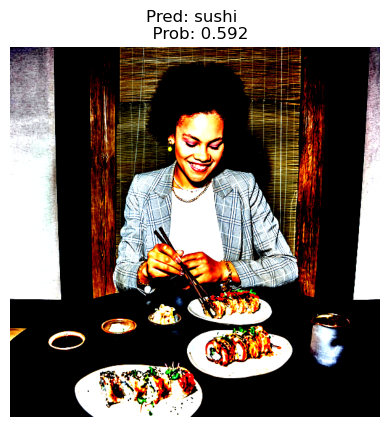

In [199]:
# TODO: Get an image of pizza/steak/sushi
test_image = Image.open(data_path / 'sushi_eating.jpg')
tranformed_test_image = weights_3.transforms()(test_image)

model_0.eval()
with torch.inference_mode():
    pred_logits = model_3(tranformed_test_image.unsqueeze(0))
    y_pred_proba = torch.softmax(pred_logits, dim=1)
    y_pred = y_pred_proba.argmax(dim=1)

    plt.imshow(tranformed_test_image.permute(1,2,0))
    plt.title(f'Pred: {class_names[y_pred]} \n  Prob: {y_pred_proba.max():.3f}')
    plt.axis(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


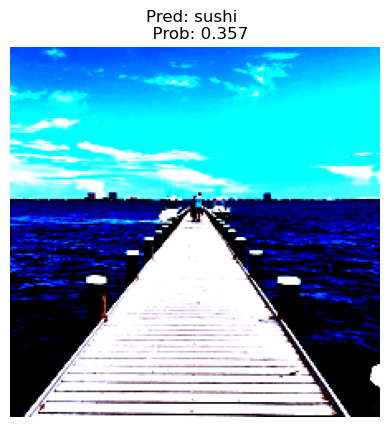

In [200]:
# TODO: Get an image of not pizza/steak/sushi
test_image = Image.open(data_path / 'non_food.jpg')
tranformed_test_image = weights.transforms()(test_image)

model_0.eval()
with torch.inference_mode():
    pred_logits = model_3(tranformed_test_image.unsqueeze(0))
    y_pred_proba = torch.softmax(pred_logits, dim=1)
    y_pred = y_pred_proba.argmax(dim=1)

    plt.imshow(tranformed_test_image.permute(1,2,0))
    plt.title(f'Pred: {class_names[y_pred]} \n  Prob: {y_pred_proba.max():.3f}')
    plt.axis(False)